# Sato-Tate-Distributions

In [57]:
import numpy as np
import matplotlib.pyplot as plt

def prime_range(n):
    """ Returns  a list of primes < n """
    sieve = [True] * n
    for i in range(3,int(n**0.5)+1,2):
        if sieve[i]:
            sieve[i*i::2*i]=[False]*((n-i*i-1)//(2*i)+1)
    return [2] + [i for i in range(3,n,2) if sieve[i]]

def values(E, N):
    """return list of a_p(E) values for p prime between 1 and N"""
    values = []
    for p in prime_range(N):
        values.append(RR(E.an(p)/sqrt(p)))
    return values

def sato_tate_histogram(E, N, buckets):
    x = values(E, int(N))
    n, bins, patches = plt.hist(x, 100, density=True)
    plt.xlabel('$a_p/\\sqrt{p}$')
    plt.ylabel('Probability')
    plt.title('Sato-Tate-Distribution for E = {}'.format(E))
    #plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
    plt.xlim(-2,2)
    #plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

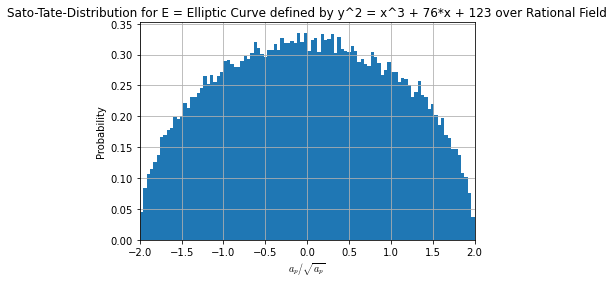

In [59]:
E = EllipticCurve([76,123])
sato_tate_histogram(E, 1e6, 100)

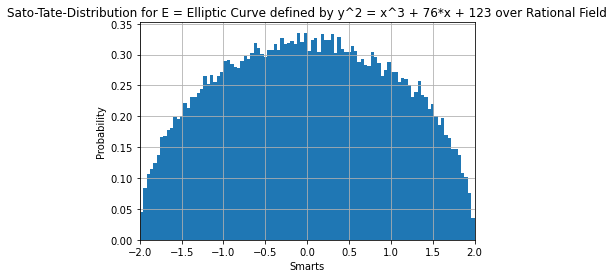

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
#np.random.seed(19680801)

#mu, sigma = 100, 15
#x = mu + sigma * np.random.randn(10000)


# the histogram of the data
n, bins, patches = plt.hist(x, 100, density=True)


plt.xlabel('Smarts')
plt.ylabel('Probability')
plt.title('Sato-Tate-Distribution for E = {}'.format(E))
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.xlim(-2,2)
#plt.ylim(0, 1)
plt.grid(True)
plt.show()